# Data Processing

In [18]:
import torch
import os
import pickle
from pathlib import Path

# This is the function you already have
def collect_global_extrema_per_feature(input_folder, attribute='y'):
    global_min, global_max = None, None
    for filename in Path(input_folder).glob('**/*.pkl'): # Use glob to find all pkl files
        with open(filename, 'rb') as f:
            graphs = pickle.load(f)
        for graph in graphs:
            feat = getattr(graph, attribute)
            current_min = torch.min(feat, dim=0).values
            current_max = torch.max(feat, dim=0).values
            if global_min is None:
                global_min, global_max = current_min, current_max
            else:
                global_min = torch.minimum(global_min, current_min)
                global_max = torch.maximum(global_max, current_max)
    return global_min, global_max

# 📁 Path to your RAW training data. 
# Note: It's best to calculate this from only the 'train' subdirectory if it exists.
# For example: Path('/scratch/jtb3sud/hecras/combined/train')
TRAINING_RAW_DIR = Path('/scratch/jtb3sud/hecras/combined')

# ✅ The new, authoritative file path for your scaling factors
EXTREMA_OUTPUT_PATH = Path('./TRAINING_Y_EXTREMA.pth')

print(f"Calculating extrema from training data in: {TRAINING_RAW_DIR}")
y_min, y_max = collect_global_extrema_per_feature(TRAINING_RAW_DIR, attribute='y')

torch.save({'y_min': y_min, 'y_max': y_max}, EXTREMA_OUTPUT_PATH)

print(f"\n✅ Successfully created the authoritative scaling file at: {EXTREMA_OUTPUT_PATH}")
print("Min values:", y_min)
print("Max values:", y_max)

Calculating extrema from training data in: /scratch/jtb3sud/hecras/combined

✅ Successfully created the authoritative scaling file at: TRAINING_Y_EXTREMA.pth
Min values: tensor([   0.0000,    0.0000, -381.1445,   -1.6552])
Max values: tensor([5.3887e+00, 2.8430e+04, 4.4518e+02, 1.4586e+00])


In [19]:
import torch
import pickle
from pathlib import Path

# 📁 Path to the new raw data you want to test on
NEW_RAW_DIR  = Path('/scratch/jtb3sud/lower_iowa_river')
# Let's create a new, clean directory for the correctly normalized output
NEW_NORM_DIR = NEW_RAW_DIR.parent / f'{NEW_RAW_DIR.name}_norm_correct'
NEW_NORM_DIR.mkdir(exist_ok=True)

# ✅ Load the authoritative scaling file from Step 1
EXTREMA_FILE_PATH = Path('./TRAINING_Y_EXTREMA.pth')
ext_y = torch.load(EXTREMA_FILE_PATH)
y_min, y_max = ext_y['y_min'], ext_y['y_max']

# This is the minmax function you already have
def minmax(feat, fmin, fmax):
    # Add a small epsilon to avoid division by zero
    return (feat - fmin) / (fmax - fmin + 1e-8) 

print(f"Normalizing new data from '{NEW_RAW_DIR.name}'...")
for pkl_file in NEW_RAW_DIR.glob('*.pkl'):
    with open(pkl_file, 'rb') as f:
        graphs = pickle.load(f)

    for g in graphs:
        # We only need to normalize the target 'y' values
        g.y = minmax(g.y, y_min, y_max)

    out_path = NEW_NORM_DIR / pkl_file.name
    with open(out_path, 'wb') as f:
        pickle.dump(graphs, f)

print(f"\n✅ Normalization complete. New files are in: {NEW_NORM_DIR}")

Normalizing new data from 'lower_iowa_river'...

✅ Normalization complete. New files are in: /scratch/jtb3sud/lower_iowa_river_norm_correct


In [20]:
import pickle
from pathlib import Path
from typing import List, Iterator

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import IterableDataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GraphUNet
from tqdm import tqdm
import matplotlib.pyplot as plt

class IterativeRolloutDataset(IterableDataset):
    """
    Yields consecutive *shifted* sequences of timesteps:
      [ (Data[t].x, Data[t+1].y), (Data[t+1].x, Data[t+2].y), ..., (Data[t+seq_len-1].x, Data[t+seq_len].y) ]
    for each simulation.
    """
    def __init__(self,
                 directory: Path,
                 hydrograph_ids: List[str],
                 seq_len: int,
                 num_static_feats: int,
                 num_dynamic_feats: int):
        """
        Args:
            directory (Path): Directory containing your pickled simulation files.
            hydrograph_ids (List[str]): List of simulation IDs (file stems).
            seq_len (int): Number of consecutive steps in each returned window.
                           NOTE: Because we shift y by +1, we actually need seq_len+1 timesteps.
            num_static_feats (int): Number of static features in data.x.
            num_dynamic_feats (int): Number of dynamic features in data.x.
        """
        super().__init__()
        self.directory = directory
        self.hydrograph_ids = hydrograph_ids
        self.seq_len = seq_len
        self.num_static_feats = num_static_feats
        self.num_dynamic_feats = num_dynamic_feats

    def __iter__(self) -> Iterator[List[Data]]:
        for hid in self.hydrograph_ids:
            pickle_file = self.directory / f"{hid}.pkl"
            try:
                with open(pickle_file, 'rb') as file:
                    sim = pickle.load(file)
                    if not isinstance(sim, list):
                        print(f"Unexpected data format in {pickle_file}. Skipping.")
                        continue
                    T = len(sim)
                    max_start = T - self.seq_len
                    if max_start < 1:
                        continue
                    for start_idx in range(max_start):
                        window = []
                        for offset in range(self.seq_len):
                            t = start_idx + offset
                            data_t = sim[t].clone()
                            # Partition x into static and dynamic parts using parameterized indices
                            static_feats = data_t.x[:, :self.num_static_feats]
                            dynamic_feats = data_t.x[:, self.num_static_feats:self.num_static_feats + self.num_dynamic_feats]
                            data_t.x = torch.cat([static_feats, dynamic_feats], dim=1)
                            # Overwrite y with next timestep's ground truth
                            data_tplus1 = sim[t+1]
                            data_t.y = data_tplus1.y.clone()
                            window.append(data_t)
                        yield window
            except FileNotFoundError:
                print(f"Pickle file not found: {pickle_file}")
            except Exception as e:
                print(f"Error loading {pickle_file}: {e}")

def get_hydrograph_ids(directory: Path) -> List[str]:
    return [file.stem for file in directory.glob("*.pkl")]
class FeatureExtractorGNN(nn.Module):
    """
    GraphUNet-based feature extractor for each node with attention.
    """
    def __init__(self, in_channels=9, hidden_channels=64, out_channels=32, depth=3, pool_ratios=0.5, heads=4, concat=True, dropout=0.6):
        super(FeatureExtractorGNN, self).__init__()
        self.unet = GraphUNet(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            depth=depth,
            pool_ratios=pool_ratios,
            act=F.relu
        )
        self.attention1 = GATConv(out_channels, out_channels, heads=heads, concat=concat, dropout=dropout)
        self.attention2 = GATConv(out_channels * heads if concat else out_channels, out_channels, heads=1, concat=False, dropout=dropout)
        self.residual = nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        residual = self.unet(x, edge_index)
        x = F.elu(self.attention1(residual, edge_index))
        x = self.attention2(x, edge_index)
        x += residual
        return x

class DerivativeGNN(nn.Module):
    """
    GNN that approximates Fdot = dF/dt using Graph Attention.
    """
    def __init__(self, in_channels, out_channels=64, heads=4, concat=True, dropout=0.6):
        super(DerivativeGNN, self).__init__()
        self.gat1 = GATConv(in_channels, 64, heads=heads, concat=concat, dropout=dropout)
        self.gat2 = GATConv(64 * heads if concat else 64, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        return x

class IntegralGNN(nn.Module):
    """
    GNN that learns the integral operator: ΔF = ∫ Fdot dt using Graph Attention.
    """
    def __init__(self, in_channels=64, out_channels=4, heads=4, concat=True, dropout=0.6):
        super(IntegralGNN, self).__init__()
        self.gat1 = GATConv(in_channels, 64, heads=heads, concat=concat, dropout=dropout)
        self.gat2 = GATConv(64 * heads if concat else 64, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        return x
    
class GPARCRecurrent(nn.Module):
    """
    Recurrent GPARC that processes a sequence of Data objects.
    The feature extractor is now integrated so that its parameters are updated during training.
    """
    def __init__(self, feature_extractor, derivative_solver, integral_solver, 
                 num_static_feats=9, num_dynamic_feats=4):
        super().__init__()
        self.feature_extractor = feature_extractor  # Integrated learnable feature extractor
        self.derivative_solver = derivative_solver
        self.integral_solver = integral_solver
        self.num_static_feats = num_static_feats
        self.num_dynamic_feats = num_dynamic_feats

    def forward(self, data_list):
        predictions = []
        F_prev = None
        # Compute the learned static feature map from the first timestep’s static features.
        static_feats_0 = data_list[0].x[:, :self.num_static_feats]
        edge_index_0 = data_list[0].edge_index
        learned_static_feature_map = self.feature_extractor(static_feats_0, edge_index_0)
        
        for data in data_list:
            x = data.x
            edge_index = data.edge_index
            # Extract dynamic features (assumed to be after the first num_static_feats columns)
            dynamic_feats_t = x[:, self.num_static_feats:self.num_static_feats + self.num_dynamic_feats]
            F_prev_used = dynamic_feats_t if F_prev is None else F_prev
            
            # Concatenate the dynamic state with the learned static feature map
            Fdot_input = torch.cat([F_prev_used, learned_static_feature_map], dim=-1)
            Fdot = self.derivative_solver(Fdot_input, edge_index)
            Fint = self.integral_solver(Fdot, edge_index)
            F_pred = F_prev_used + Fint
            predictions.append(F_pred)
            F_prev = F_pred
        return predictions

# Make Dataloader

In [22]:
# Define paths and parameters
base_directory = Path("/scratch/jtb3sud/lower_iowa_river_norm_correct")
train_dir = base_directory# / "train"       # Replace with actual train data path
val_dir   = base_directory #/ "val"         # Replace with actual validation data path
test_dir  = base_directory #/ "test"  # Replace with actual test data path

# Get hydrograph IDs
train_ids = get_hydrograph_ids(train_dir)
val_ids   = get_hydrograph_ids(val_dir)
test_ids  = get_hydrograph_ids(test_dir)
print(f"[Data] #Train IDs = {len(train_ids)}, #Val IDs = {len(val_ids)}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1) Initialize Dataset
seq_len = 1
num_static_feats=9
num_dynamic_feats=4

train_dataset = IterativeRolloutDataset(
    directory=train_dir,
    hydrograph_ids=train_ids,
    seq_len=seq_len,
    num_static_feats=num_static_feats,
    num_dynamic_feats=num_dynamic_feats
)

# 2) Wrap in DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=None,  # Because it's an IterableDataset of variable sequence lengths
    shuffle=False,
    num_workers=0
)

val_dataset = IterativeRolloutDataset(
    directory=val_dir,
    hydrograph_ids=val_ids,
    seq_len=seq_len,
    num_static_feats=num_static_feats,
    num_dynamic_feats=num_dynamic_feats
)

# 2) Wrap in DataLoader
val_loader = DataLoader(
    val_dataset,
    batch_size=None,  # Because it's an IterableDataset of variable sequence lengths
    shuffle=False,
    num_workers=0
)

test_dataset = IterativeRolloutDataset(
    directory=test_dir,
    hydrograph_ids=test_ids,
    seq_len=seq_len,
    num_static_feats=num_static_feats,
    num_dynamic_feats=num_dynamic_feats
)

# 2) Wrap in DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=None,  # Because it's an IterableDataset of variable sequence lengths
    shuffle=False,
    num_workers=0
)
print("SEQUENCE LENGTH", seq_len)

[Data] #Train IDs = 10, #Val IDs = 10
Using device: cuda
SEQUENCE LENGTH 1


In [23]:
# Instantiate submodules as before.
feature_extractor = FeatureExtractorGNN(
    in_channels=num_static_feats,
    hidden_channels=64,
    out_channels=128,
    depth=2,
    pool_ratios=0.1,
    heads=4,
    concat=True,
    dropout=0.2
).to(device)

derivative_solver = DerivativeGNN(
    in_channels=128 + num_dynamic_feats,  # 128 from feature extractor + dynamic features
    out_channels=4,
    heads=4,
    concat=True,
    dropout=0.2
).to(device)

integral_solver = IntegralGNN(
    in_channels=4,
    out_channels=num_dynamic_feats,
    heads=4,
    concat=True,
    dropout=0.2
).to(device)

# Now integrate them in the recurrent model:
model = GPARCRecurrent(
    feature_extractor=feature_extractor,
    derivative_solver=derivative_solver,
    integral_solver=integral_solver,
    num_static_feats=num_static_feats,
    num_dynamic_feats=num_dynamic_feats
).to(device)


# Load Model

In [24]:
def load_model(model, model_path, device="cpu"):
    if Path(model_path).exists():
        print(f"Loading checkpoint from {model_path}")
        checkpoint = torch.load(model_path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Loaded checkpoint for the integrated model.")
        else:
            model.load_state_dict(checkpoint)
            print("Loaded model checkpoint (only model).")
    else:
        print("No checkpoint provided. Training from scratch.")
    model.to(device)
    model.eval()  # Set to evaluation mode
    return model

# Example usage:
model_path = "/home/jtb3sud/G-PARC/weights/new_river/modelseq20_ep250.pth"  # Change this to your actual model path
model = load_model(model, model_path, device)


Loading checkpoint from /home/jtb3sud/G-PARC/weights/new_river/modelseq20_ep250.pth
Loaded checkpoint for the integrated model.


Found 10 correctly normalized simulation files.
Using authoritative scaling file from: TRAINING_Y_EXTREMA.pth
Aggregated Water Depth [0] over 21 timesteps
Aggregated Volume [1] over 21 timesteps
Aggregated Velocity X [2] over 21 timesteps
Aggregated Velocity Y [3] over 21 timesteps
Determined segments for plotting: [(1, 22)]

--- Plotting Denormalized Data Ranges ---
Variable: Water Depth
  - Ground Truth Range: [0.2707, 0.4447]
  - Prediction Range:   [4.4270, 42.1643]
Variable: Volume
  - Ground Truth Range: [561.6071, 901.0548]
  - Prediction Range:   [26547803.4000, 26833556.8000]
Variable: Velocity X
  - Ground Truth Range: [0.1115, 0.2320]
  - Prediction Range:   [-11387.6864, -718.5296]
Variable: Velocity Y
  - Ground Truth Range: [0.0034, 0.0064]
  - Prediction Range:   [-11.1804, -2.1098]

✅ Figure saved as final_evaluation_plot.png


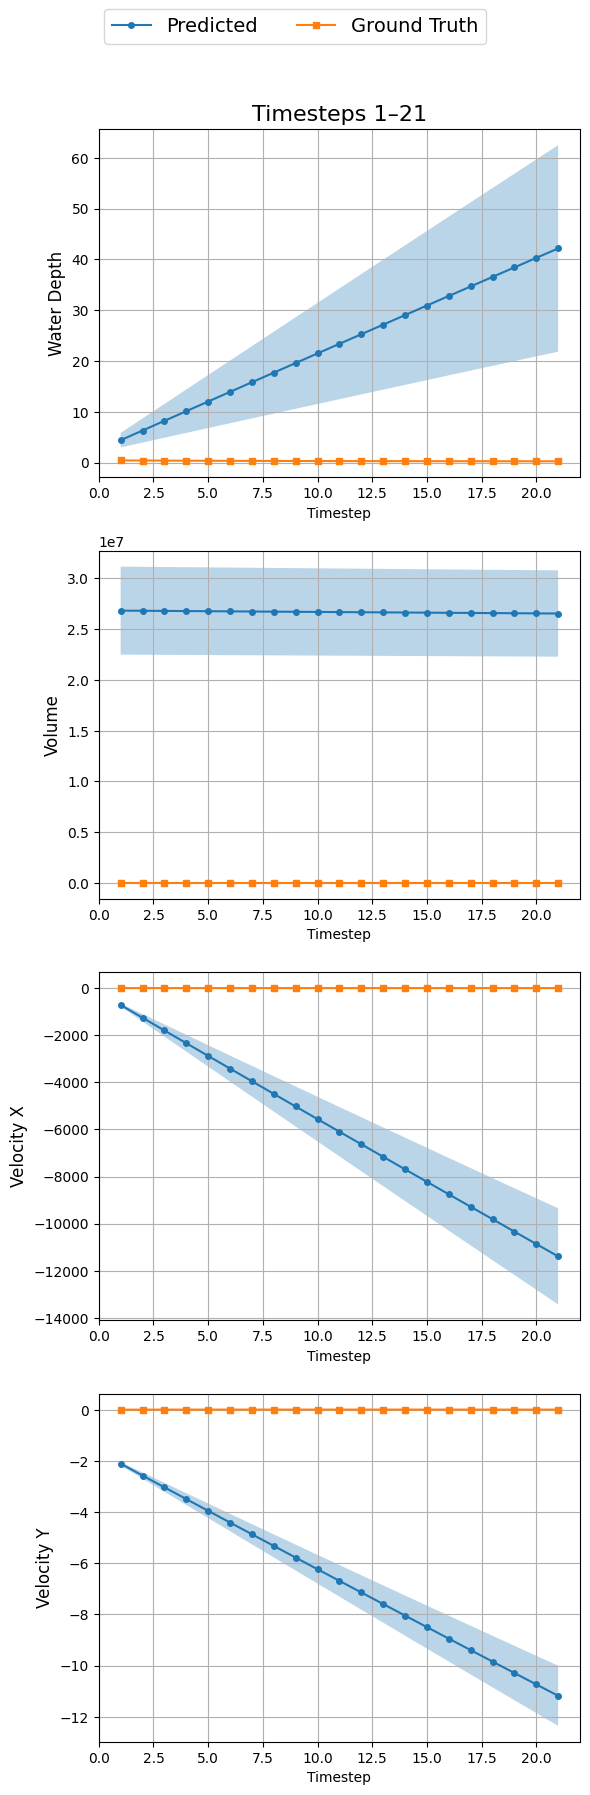

In [25]:
import pickle
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

# ===================================================================
#                           CONFIGURATION
# ===================================================================

# 📁 Point to your new, correctly normalized data directory
simulation_files_dir = Path("/scratch/jtb3sud/lower_iowa_river_norm_correct")
simulation_files = sorted(list(simulation_files_dir.glob("*.pkl")))

# ✅ Point to your authoritative scaling file
EXTREMA_PATH = Path('./TRAINING_Y_EXTREMA.pth')

# Load the scaling factors that will be used for denormalization
ext = torch.load(EXTREMA_PATH)
y_mins, y_maxs = ext['y_min'].to(device), ext['y_max'].to(device)

print(f"Found {len(simulation_files)} correctly normalized simulation files.")
print(f"Using authoritative scaling file from: {EXTREMA_PATH}")


# ===================================================================
#                        HELPER FUNCTIONS
# (Using the same functions from your notebook for consistency)
# ===================================================================

FEATURE_MAPPING = {0: "Water Depth", 1: "Volume", 2: "Velocity X", 3: "Velocity Y"}

def get_important_mask(graphs, num_static_feats, pred_idx, threshold=0.0):
    n = graphs[0].x.size(0)
    mask = torch.zeros(n, dtype=torch.bool, device=device)
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    for i in range(n):
        norm0 = graphs[0].x[i, num_static_feats + pred_idx]
        val0  = norm0 * (y_max - y_min) + y_min
        if val0.item() > threshold:
            mask[i] = True
            continue
        for g in graphs[1:]:
            normv = g.y[i, pred_idx]
            val   = normv * (y_max - y_min) + y_min
            if val.item() > threshold:
                mask[i] = True
                break
    return mask

def evaluate_avg_values(graphs, model, device, num_static_feats, pred_idx):
    mask = get_important_mask(graphs, num_static_feats, pred_idx, threshold=0.0)
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    current = graphs[0].clone().to(device)
    avg_pred, avg_gt = [], []

    for t in range(len(graphs) - 1):
        with torch.no_grad():
            F_pred = model([current])[0]
        pred_norm = F_pred[:, pred_idx]
        gt_norm = graphs[t+1].y[:, pred_idx].to(device)
        pred_phys = pred_norm * (y_max - y_min) + y_min
        gt_phys = gt_norm * (y_max - y_min) + y_min
        avg_pred.append(pred_phys[mask].mean().item())
        avg_gt.append(gt_phys[mask].mean().item())
        current.x[:, num_static_feats:] = F_pred
    return avg_pred, avg_gt

def aggregate_avg_values_variable_return(simulation_files, model, device, num_static_feats, pred_idx):
    all_pred, all_gt, lengths = [], [], []
    for fpath in simulation_files:
        with open(fpath, 'rb') as f:
            graphs = pickle.load(f)
        pred, gt = evaluate_avg_values(graphs, model, device, num_static_feats, pred_idx)
        all_pred.append(pred)
        all_gt.append(gt)
        lengths.append(len(pred))
    
    max_len = max(lengths) if lengths else 0
    t_steps = np.arange(1, max_len + 1)
    pm, ps, gm, gs = [], [], [], []
    for i in range(max_len):
        vals_p = [a[i] for a in all_pred if len(a) > i]
        vals_g = [a[i] for a in all_gt if len(a) > i]
        if vals_p: pm.append(np.mean(vals_p)); ps.append(np.std(vals_p))
        if vals_g: gm.append(np.mean(vals_g)); gs.append(np.std(vals_g))
        
    return t_steps, np.array(pm), np.array(ps), np.array(gm), np.array(gs), FEATURE_MAPPING[pred_idx]

def determine_time_segments(simulation_files, min_segment_length=10, drop_threshold=0.8):
    if not simulation_files: return [], None, None
    lengths = []
    for f in simulation_files:
        with open(f, 'rb') as file:
            lengths.append(len(pickle.load(file)) - 1)
    lengths = np.array(lengths)
    max_len = lengths.max()
    counts = np.array([np.sum(lengths >= t) for t in range(1, max_len + 1)])
    segments, start = [], 1
    for t in range(1, max_len):
        if counts[t] < counts[t-1] * drop_threshold:
            if (t + 1 - start) >= min_segment_length:
                segments.append((start, t + 1))
                start = t + 1
    if (max_len + 1 - start) >= min_segment_length:
        segments.append((start, max_len + 1))
    if not segments and max_len > 0:
        segments.append((1, max_len + 1))
    return segments, counts, lengths

def plot_segments_grid_multiple_variables(timesteps, list_pred_means, list_pred_stds, list_gt_means, list_gt_stds, list_feature_names, segments, output_filename):
    n_vars = len(list_pred_means)
    num_segments = len(segments)
    if num_segments == 0: print("No segments to plot."); return

    fig, axes = plt.subplots(n_vars, num_segments, figsize=(num_segments * 6, n_vars * 4.5), squeeze=False, sharey='row')
    print("\n--- Plotting Denormalized Data Ranges ---")
    for i in range(n_vars):
        pm, ps, gm, gs = list_pred_means[i], list_pred_stds[i], list_gt_means[i], list_gt_stds[i]
        feature_name = list_feature_names[i]
        print(f"Variable: {feature_name}")
        if gm.size > 0: print(f"  - Ground Truth Range: [{gm.min():.4f}, {gm.max():.4f}]")
        if pm.size > 0: print(f"  - Prediction Range:   [{pm.min():.4f}, {pm.max():.4f}]")

        y_low = min((pm - ps).min(), (gm - gs).min()) if pm.size > 0 and gm.size > 0 else 0
        y_high = max((pm + ps).max(), (gm + gs).max()) if pm.size > 0 and gm.size > 0 else 1
        
        for j, (start, end) in enumerate(segments):
            ax = axes[i][j]
            idx = np.where((timesteps >= start) & (timesteps < end))[0]
            if idx.size == 0: ax.axis('off'); continue
            
            l1, = ax.plot(timesteps[idx], pm[idx], marker='o', markersize=4, label="Predicted")
            ax.fill_between(timesteps[idx], pm[idx] - ps[idx], pm[idx] + ps[idx], alpha=0.3)
            l2, = ax.plot(timesteps[idx], gm[idx], marker='s', markersize=4, label="Ground Truth")
            ax.fill_between(timesteps[idx], gm[idx] - gs[idx], gm[idx] + gs[idx], alpha=0.3)
            
            if i == 0: ax.set_title(f"Timesteps {start}–{end-1}", fontsize=16)
            ax.set_xlabel("Timestep"); ax.grid(True)
            if j == 0: ax.set_ylabel(f"{feature_name}", fontsize=12)

    fig.legend(handles=[l1, l2], loc="upper center", ncol=2, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    print(f"\n✅ Figure saved as {output_filename}")
    plt.show()

# ===================================================================
#                         MAIN EXECUTION
# ===================================================================

list_pred_means, list_pred_stds = [], []
list_gt_means, list_gt_stds = [], []
list_feature_names = []

for pred_idx in range(4):
    timesteps, pm, ps, gm, gs, fname = aggregate_avg_values_variable_return(
        simulation_files, model, device, num_static_feats, pred_idx
    )
    print(f"Aggregated {fname} [{pred_idx}] over {len(timesteps)} timesteps")
    list_pred_means.append(pm)
    list_pred_stds.append(ps)
    list_gt_means.append(gm)
    list_gt_stds.append(gs)
    list_feature_names.append(fname)

segments, _, _ = determine_time_segments(simulation_files)
print(f"Determined segments for plotting: {segments}")

plot_segments_grid_multiple_variables(
    timesteps,
    list_pred_means, list_pred_stds,
    list_gt_means, list_gt_stds,
    list_feature_names, segments,
    output_filename="final_evaluation_plot.png"
)

In [28]:
import torch
import pickle
from pathlib import Path

# --- Configuration ---

# 📁 Path to the new raw data you are testing on
#RAW_DATA_DIR = Path('/scratch/jtb3sud/lower_iowa_river')
RAW_DATA_DIR = Path('/scratch/jtb3sud/hecras/combined/train')
# You can change this to any of the .pkl files in that directory
# We'll use 'H8ds.pkl' as an example
FILE_TO_INSPECT = RAW_DATA_DIR / 'H101iw.pkl'

# The index for 'Volume' in your y-tensor is 1
VOLUME_FEATURE_INDEX = 1

# --- Execution ---

print(f"🔎 Inspecting ground truth file: {FILE_TO_INSPECT}")

# Check if the file exists
if not FILE_TO_INSPECT.exists():
    print(f"❌ ERROR: File not found at {FILE_TO_INSPECT}")
else:
    # Load the raw pickle file
    with open(FILE_TO_INSPECT, 'rb') as f:
        raw_graphs = pickle.load(f)

    # Collect all 'y' values for the volume feature from all timesteps
    # The 'y' attribute holds the ground truth target values
    all_volume_values = torch.cat([g.y[:, VOLUME_FEATURE_INDEX] for g in raw_graphs])

    # Find the minimum and maximum values
    min_volume = all_volume_values.min().item()
    max_volume = all_volume_values.max().item()

    print("\n--- Value Range for 'Volume' ---")
    print(f"Minimum Volume: {min_volume:,.4f}")
    print(f"Maximum Volume: {max_volume:,.4f}")

🔎 Inspecting ground truth file: /scratch/jtb3sud/hecras/combined/train/H101iw.pkl

--- Value Range for 'Volume' ---
Minimum Volume: 0.0000
Maximum Volume: 9,403.6357


# Denormalize

In [7]:
def collect_global_extrema_per_feature(input_folder, attribute='x'):
    """
    Computes the global minimum and maximum for each feature dimension
    across all simulation files.
    
    Returns:
        global_min: Tensor of shape [feature_dim]
        global_max: Tensor of shape [feature_dim]
    """
    global_min = None
    global_max = None

    for filename in os.listdir(input_folder):
        if filename.endswith('.pkl'):
            file_path = os.path.join(input_folder, filename)
            with open(file_path, 'rb') as f:
                graphs = pickle.load(f)
            for graph in graphs:
                feat = getattr(graph, attribute)
                # feat shape: [n_nodes, feature_dim]
                current_min = torch.min(feat, dim=0).values
                current_max = torch.max(feat, dim=0).values
                if global_min is None:
                    global_min = current_min
                    global_max = current_max
                else:
                    global_min = torch.minimum(global_min, current_min)
                    global_max = torch.maximum(global_max, current_max)
    
    if global_min is None or global_max is None:
        raise ValueError(f"No attribute '{attribute}' found in any file.")
    # Check for division by zero (if any feature dimension has constant value)
    if torch.any(global_max == global_min):
        raise ValueError(f"At least one feature in '{attribute}' has constant values; cannot normalize.")
    return global_min, global_max

#raw_folder = '/scratch/jtb3sud/combined/test'
#raw_folder =  '/scratch/jtb3sud/hecras/combined/test'
#
#global_y_min, global_y_max = collect_global_extrema_per_feature(
#    raw_folder,
#    attribute='y'
#)
#
# (Optionally save them so you don’t have to recompute)
#import torch
#torch.save({'y_min': global_y_min, 'y_max': global_y_max},
#           'global_y_extrema_test.pth')

ext = torch.load('/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth') # Ensure this is the correct path
y_min, y_max = ext['y_min'], ext['y_max']

print("Loaded consistent extrema for denormalization.")
print(y_min, y_max)


Loaded consistent extrema for denormalization.
tensor([   0.0000,    0.0000, -375.0542,   -1.6482]) tensor([5.3710e+00, 2.8327e+04, 4.3768e+02, 1.4451e+00])


In [9]:
import imageio
import shutil
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
import numpy as np
import h5py
from matplotlib.collections import PolyCollection
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def load_static_mesh(hdf_path, facepts_ds, cells_ds):
    with h5py.File(hdf_path, "r") as f:
        facepts = f[facepts_ds][:]
        cells   = f[cells_ds][:]
    print(f"[mesh] loaded {len(facepts)} verts, {len(cells)} cells")
    return facepts, cells

def make_poly_collection(facepts, cells, values, cmap_name="viridis", vmin=None, vmax=None):
    polys, vals = [], []
    for vert_ids, v in zip(cells, values):
        mask = (vert_ids >= 0) & (vert_ids < len(facepts))
        pts  = facepts[vert_ids[mask]]
        if len(pts) < 3: continue
        polys.append(pts)
        vals.append(v)
    vals = np.array(vals)
    if vmin is None: vmin = vals.min()
    if vmax is None: vmax = vals.max()
    if vmax == vmin: vmax = vmin + 1e-6
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(cmap_name)
    facec = cmap(norm(vals))
    return PolyCollection(polys, facecolors=facec, edgecolors="k", linewidths=0.2)

def create_rollout_gif_from_t0(
    norm_graphs_path: Path,
    extrema_path: Path,
    model: torch.nn.Module,
    device: torch.device,
    pred_idx: int,
    output_path: Path,
    mesh_hdf_path: Path,
    facepts_ds: str,
    cells_ds: str,
    frame_duration: float = 0.5,
    max_timesteps: int = 200
):
    # 1) Load mesh
    facepts, all_cells = load_static_mesh(mesh_hdf_path, facepts_ds, cells_ds)
    Xmin, Xmax = facepts[:,0].min(), facepts[:,0].max()
    Ymin, Ymax = facepts[:,1].min(), facepts[:,1].max()

    # 2) Load global extents (for denorm only)
    ext = torch.load(extrema_path)
    y_min, y_max = ext['y_min'], ext['y_max']

    # 3) Load normalized graphs
    with open(norm_graphs_path, 'rb') as f:
        norm_graphs = pickle.load(f)

    # 4) Compute simulation-specific range on GT
    dyn_off = norm_graphs[0].x.shape[1] - model.num_dynamic_feats
    n_steps = min(max_timesteps, len(norm_graphs) - 1)
    all_vals = []
    for g in norm_graphs[:n_steps]:
        gt_n = g.x[:, dyn_off + pred_idx]
        gt_d = gt_n * (y_max[pred_idx] - y_min[pred_idx]) + y_min[pred_idx]
        all_vals.append(gt_d.cpu().numpy())
    concat = np.concatenate(all_vals)
    vmin, vmax = float(concat.min()), float(concat.max())
    print(f"Using SIM-specific range: {vmin:.3f} → {vmax:.3f}")
    norm_vis = Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap("viridis")

    # 5) Rollout & render
    current = norm_graphs[0].to(device)
    # Map nodes → cells (fallback to identity)
    if hasattr(current, 'cell_ids'):
        ids = current.cell_ids.cpu().numpy().astype(int)
    else:
        ids = np.arange(current.x.shape[0], dtype=int)
    cells = [all_cells[i] for i in ids]

    tmp = Path("temp_frames"); tmp.mkdir(exist_ok=True)
    frames = []; model.eval()
    for t in range(n_steps):
        with torch.no_grad():
            pred = model([current])[0]

        gt_n = current.x[:, dyn_off + pred_idx]
        pr_n = pred[:, pred_idx]
        gt_d = (gt_n * (y_max[pred_idx] - y_min[pred_idx]) + y_min[pred_idx]).cpu().numpy()
        pr_d = (pr_n * (y_max[pred_idx] - y_min[pred_idx]) + y_min[pred_idx]).cpu().numpy()

        if t == 0:
            print(f"Frame0 GT: {gt_d.min():.3f}/{gt_d.max():.3f}, PR: {pr_d.min():.3f}/{pr_d.max():.3f}")

        fig, (aL, aR) = plt.subplots(1,2,figsize=(12,6), constrained_layout=True)
        pcL = make_poly_collection(facepts, cells, gt_d, vmin=vmin, vmax=vmax)
        pcR = make_poly_collection(facepts, cells, pr_d, vmin=vmin, vmax=vmax)
        for ax, pc, title in [(aL, pcL, f"GT t+1={t+1}"), (aR, pcR, f"Pred t→t+1={t}")]:
            ax.add_collection(pc); ax.relim(); ax.autoscale_view()
            ax.set_xlim(Xmin,Xmax); ax.set_ylim(Ymin,Ymax)
            ax.axis("off"); ax.set_title(title)
        sm = ScalarMappable(norm=norm_vis, cmap=cmap); sm.set_array([])
        fig.colorbar(sm, ax=(aL,aR), fraction=0.02, pad=0.04).set_label("Volume")

        fn = tmp/f"frame_{t:04d}.png"
        fig.savefig(fn); plt.close(fig)
        frames.append(imageio.v2.imread(fn))

        current = current.clone()
        nx = current.x.clone(); nx[:, dyn_off:] = pred; current.x = nx

    if frames:
        imageio.mimsave(str(output_path), frames, duration=frame_duration, loop=0)
        print(f"[ok] GIF saved to {output_path}")
    else:
        print("[error] no frames")
    shutil.rmtree(tmp)

# Example usage:
# create_rollout_gif_from_t0(
#     Path(".../normalized.pkl"),
#     Path(".../physical_extrema.pth"),
#     model, torch.device("cuda"), 1,
#     Path("out.gif"),
#     Path("mesh.hdf5"),
#     "FacePts", "Cells", 0.5, 100
# )


# Lower

In [10]:
# %% Cell 3: Run the rollout with the PHYSICAL extrema
from pathlib import Path
import torch
# normalized input for the model…
norm_file   = Path("/scratch/jtb3sud/lower_iowa_river_norm/H8ds.pkl")
extrema_pt  = Path("/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth")

# %% Cell 3: Run rollout
def main():
    norm_file  = Path("/scratch/jtb3sud/lower_iowa_river_norm/H8ds.pkl")
    extrema_pt = Path("/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth")
    create_rollout_gif_from_t0(
        norm_graphs_path=norm_file,
        extrema_path=extrema_pt,
        model=model,
        device=torch.device("cuda"),
        pred_idx=1,
        output_path=Path("/home/jtb3sud/G-PARC/demos/new_river/volumerollout_lower.gif"),
        mesh_hdf_path=Path("/home/jtb3sud/G-PARC/demos/mesh_cells/lower.p01.hdf"),
        facepts_ds="Geometry/2D Flow Areas/Perimeter 1/FacePoints Coordinate",
        cells_ds="Geometry/2D Flow Areas/Perimeter 1/Cells FacePoint Indexes",
        frame_duration=150,
        max_timesteps=100
    )

if __name__ == "__main__":
    main()


[mesh] loaded 2525 verts, 2395 cells
Using SIM-specific range: 0.000 → 212707664.000


/home/jtb3sud/.local/lib/python3.10/site-packages/torch_geometric/utils/sparse.py:277: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj = torch.sparse_csr_tensor(


Frame0 GT: 0.000/212707664.000, PR: -19963.607/212669120.000
[ok] GIF saved to /home/jtb3sud/G-PARC/demos/new_river/volumerollout_lower.gif


# Viz

In [11]:
import pickle
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import math
import h5py

# ---------------------------
# Global Configuration
# ---------------------------
FEATURE_MAPPING = {
    0: "Water Depth",
    1: "Volume",
    2: "Velocity X",
    3: "Velocity Y"
}

# ---------------------------
# Helper Function Definitions
# ---------------------------

def load_static_mesh(hdf_path: Path, facepts_ds: str, cells_ds: str):
    """Load mesh vertices and cell-to-vertex connectivity from HDF5."""
    with h5py.File(hdf_path, "r") as f:
        facepts = f[facepts_ds][:]
        cells   = f[cells_ds][:]
    print(f"[mesh] loaded {len(facepts)} verts, {len(cells)} cells")
    return facepts, cells


def get_important_mask(graphs, num_static_feats: int, pred_idx: int, threshold: float = 0.0):
    """
    Returns a boolean mask of graph nodes (one per mesh cell) that ever exceed
    the threshold in denormalized physical units for feature pred_idx.
    """
    n = graphs[0].x.size(0)
    mask = torch.zeros(n, dtype=torch.bool)
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    for i in range(n):
        # t=0
        norm0 = graphs[0].x[i, num_static_feats + pred_idx]
        val0  = norm0 * (y_max - y_min) + y_min
        if val0.item() > threshold:
            mask[i] = True
            continue
        # later timesteps
        for g in graphs[1:]:
            normv = g.y[i, pred_idx] if hasattr(g, 'y') else g.x[i, num_static_feats + pred_idx]
            val   = normv * (y_max - y_min) + y_min
            if val.item() > threshold:
                mask[i] = True
                break
    return mask


def visualize_important_nodes_for_simulation(
    file_path: Path,
    num_static_feats: int,
    pred_idx: int,
    mesh_hdf_path: Path,
    facepts_ds: str,
    cells_ds: str,
    threshold: float = 0.0,
    save_path: Path = None
):
    """
    Plot the mesh with cells colored red if the corresponding graph node's
    denormalized value at t=0 (feature pred_idx) exceeds threshold.
    """
    # Load simulation
    graphs = pickle.load(open(file_path, 'rb'))
    # Compute mask of important nodes (one per mesh cell)
    mask = get_important_mask(graphs, num_static_feats, pred_idx, threshold).numpy()
    # Load mesh
    facepts, cells = load_static_mesh(mesh_hdf_path, facepts_ds, cells_ds)

    polys, cols = [], []
    for cell_idx, vert_ids in enumerate(cells):
        # get vertex coordinates
        valid = (vert_ids >= 0) & (vert_ids < len(facepts))
        pts = facepts[vert_ids[valid].astype(int)]
        if len(pts) < 3:
            continue
        polys.append(pts)
        cols.append(1 if mask[cell_idx] else 0)
    cols = np.array(cols)

    cmap = ListedColormap(['#e0e0e0', '#7eaedb'])
    pc = PolyCollection(
        polys,
        facecolors=cmap(cols),
        edgecolors='k',
        linewidths=0.2
    )

    fig, ax = plt.subplots(figsize=(8,6))
    ax.add_collection(pc)
    ax.autoscale_view()
    ax.axis('off')
    ax.set_title(f"Important Nodes (> {threshold:.2f}) for {FEATURE_MAPPING[pred_idx]}", fontsize=14)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()




def evaluate_avg_values(graphs, feature_extractor, model, device, num_static_feats, pred_idx):
    """
    Runs an autoregressive rollout for one sim and returns lists of
    average denormalized prediction and GT over important nodes per timestep.
    """
    mask = get_important_mask(graphs, num_static_feats, pred_idx, threshold=0.0).to(device)
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]

    current = graphs[0].clone().to(device)
    avg_pred, avg_gt = [], []

    for t in range(len(graphs) - 1):
        with torch.no_grad():
            F_pred = model([current])[0]                          # shape [n_nodes, n_dyn_feats]
        # extract normalized arrays
        pred_norm = F_pred[:, pred_idx]
        gt_graph  = graphs[t+1]
        gt_norm   = (gt_graph.y[:, pred_idx] if hasattr(gt_graph, 'y')
                     else gt_graph.x[:, num_static_feats + pred_idx]).to(device)

        # denormalize
        pred_phys = pred_norm * (y_max - y_min) + y_min
        gt_phys   = gt_norm  * (y_max - y_min) + y_min

        # average over important nodes
        avg_pred.append(pred_phys[mask].mean().item())
        avg_gt.append  (gt_phys[mask].mean().item())

        # update for next step
        current = current.clone()
        x_new   = current.x.clone()
        x_new[:, num_static_feats:] = F_pred
        current.x = x_new

    return avg_pred, avg_gt


def aggregate_avg_values(simulation_files, feature_extractor, model, device,
                         num_static_feats, pred_idx, threshold=0.0):
    """
    Aggregates average curves (important nodes) across sims and plots mean±1σ.
    """
    # determine min rollout length
    min_len = min(
        (len(pickle.load(open(f, 'rb'))) - 1)
        for f in simulation_files
    )
    print(f"Using rollout length = {min_len}")
    all_pred, all_gt = [], []
    for fpath in simulation_files:
        graphs = pickle.load(open(fpath, 'rb'))
        pred, gt = evaluate_avg_values(graphs, feature_extractor,
                                       model, device,
                                       num_static_feats, pred_idx)
        all_pred.append(pred[:min_len])
        all_gt.append(  gt[:min_len])

    all_pred = np.array(all_pred)
    all_gt   = np.array(all_gt)
    t = np.arange(1, min_len + 1)
    pm, ps = all_pred.mean(0), all_pred.std(0)
    gm, gs = all_gt.mean(0),   all_gt.std(0)
    name = FEATURE_MAPPING[pred_idx]

    plt.figure(figsize=(8,6))
    plt.plot(t, pm, marker='o', label="Predicted")
    plt.fill_between(t, pm-ps, pm+ps, alpha=0.3)
    plt.plot(t, gm, marker='s', label="Ground Truth")
    plt.fill_between(t, gm-gs, gm+gs, alpha=0.3)
    plt.title(f"{name} (important nodes)")
    plt.xlabel("Timestep")
    plt.ylabel("Physical Value")
    plt.legend()
    plt.grid(True)
    plt.show()


def aggregate_avg_values_variable_return(simulation_files, feature_extractor, model, device,
                                         num_static_feats, pred_idx, threshold=0.0):
    """
    Same as above, but returns (timesteps, pm, ps, gm, gs, feature_name)
    """
    all_pred, all_gt, lengths = [], [], []
    for fpath in simulation_files:
        graphs = pickle.load(open(fpath, 'rb'))
        pred, gt = evaluate_avg_values(graphs, feature_extractor,
                                       model, device,
                                       num_static_feats, pred_idx)
        all_pred.append(pred)
        all_gt.append(  gt)
        lengths.append(len(pred))
    max_len = max(lengths)
    t = np.arange(1, max_len + 1)
    pm, ps, gm, gs = [], [], [], []
    for i in range(max_len):
        vals_p = [a[i] for a in all_pred if len(a) > i]
        vals_g = [a[i] for a in all_gt   if len(a) > i]
        pm.append(np.mean(vals_p)); ps.append(np.std(vals_p))
        gm.append(np.mean(vals_g)); gs.append(np.std(vals_g))
    return t, np.array(pm), np.array(ps), np.array(gm), np.array(gs), FEATURE_MAPPING[pred_idx]


def plot_segments(timesteps, pm, ps, gm, gs, feature_name, segments):
    """
    Plots sub‐ranges of the average curves, given segment boundaries.
    """
    for (s,e) in segments:
        idx = np.where((timesteps>=s)&(timesteps<e))[0]
        if len(idx)==0: continue
        plt.figure(figsize=(8,6))
        plt.plot(timesteps[idx], pm[idx], marker='o', label="Pred")
        plt.fill_between(timesteps[idx], pm[idx]-ps[idx], pm[idx]+ps[idx], alpha=0.3)
        plt.plot(timesteps[idx], gm[idx], marker='s', label="GT")
        plt.fill_between(timesteps[idx], gm[idx]-gs[idx], gm[idx]+gs[idx], alpha=0.3)
        plt.title(f"{feature_name} (timesteps {s}–{e})")
        plt.xlabel("Timestep"); plt.ylabel("Value")
        plt.legend(); plt.grid(True)
        plt.show()


def determine_time_segments(simulation_files, min_segment_length=10, drop_threshold=0.8):
    """
    Splits the rollout into time segments based on how many sims remain.
    """
    lengths = np.array([len(pickle.load(open(f,'rb')))-1 for f in simulation_files])
    max_len = lengths.max()
    counts  = np.array([np.sum(lengths>=t) for t in range(1, max_len+1)])
    segments, start = [], 1
    for t in range(1, max_len):
        if counts[t] < counts[t-1] * drop_threshold:
            if (t+1 - start) >= min_segment_length:
                segments.append((start, t+1))
                start = t+1
    if (max_len+1 - start) >= min_segment_length:
        segments.append((start, max_len+1))
    return segments, counts, lengths


def evaluate_correlation(graphs, feature_extractor, model, device, num_static_feats, pred_idx):
    """
    Rollout one sim, collect denormalized pred vs gt for every node & timestep.
    """
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    current = graphs[0].clone().to(device)
    preds, gts = [], []
    for t in range(len(graphs)-1):
        with torch.no_grad():
            F_pred = model([current])[0]
        # normalized
        pnorm = F_pred[:, pred_idx].cpu().numpy()
        gnorm = ((graphs[t+1].y[:,pred_idx] if hasattr(graphs[t+1],'y')
                  else graphs[t+1].x[:, num_static_feats+pred_idx])
                 .cpu().numpy())
        # denormalize
        p = pnorm * (y_max-y_min) + y_min
        g = gnorm * (y_max-y_min) + y_min
        preds.extend(p.tolist())
        gts.extend(g.tolist())
        # update
        current = current.clone()
        x_new = current.x.clone()
        x_new[:, num_static_feats:] = F_pred
        current.x = x_new
    return preds, gts


def compute_correlation_metric(simulation_files, feature_extractor, model, device, num_static_feats, pred_idx):
    """
    Pearson r over all sims.
    """
    all_p, all_g = [], []
    for fpath in simulation_files:
        graphs = pickle.load(open(fpath, 'rb'))
        p, g = evaluate_correlation(graphs, feature_extractor,
                                    model, device,
                                    num_static_feats, pred_idx)
        all_p.extend(p); all_g.extend(g)
    corr = np.corrcoef(all_g, all_p)[0,1]
    return corr


def correlation_plot(simulation_files, feature_extractor, model, device, num_static_feats, pred_idx):
    """
    Scatter plot of GT vs Pred with Pearson r.
    """
    p, g = [], []
    for f in simulation_files:
        graphs = pickle.load(open(f,'rb'))
        pp, gg = evaluate_correlation(graphs, feature_extractor,
                                      model, device,
                                      num_static_feats, pred_idx)
        p.extend(pp); g.extend(gg)
    corr = np.corrcoef(g, p)[0,1]
    print(f"Pearson r = {corr:.3f}")
    plt.figure(figsize=(8,6))
    plt.scatter(g, p, alpha=0.3)
    m, M = min(min(g), min(p)), max(max(g), max(p))
    plt.plot([m,M],[m,M],'r--')
    plt.xlabel("Ground Truth"); plt.ylabel("Prediction")
    plt.title(f"{FEATURE_MAPPING[pred_idx]} Correlation")
    plt.grid(True)
    plt.show()


def evaluate_nonimportant_changes(graphs, feature_extractor, model, device, num_static_feats, pred_idx):
    """
    Rollout one sim, compute avg absolute change from t0 for non-important nodes.
    """
    mask_imp = get_important_mask(graphs, num_static_feats, pred_idx, threshold=0.0)
    mask_non = (~mask_imp).to(device)
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    init_norm = graphs[0].x[:, num_static_feats+pred_idx].to(device)
    init_phys = init_norm * (y_max-y_min) + y_min

    current = graphs[0].clone().to(device)
    pred_changes, gt_changes = [], []
    for t in range(len(graphs)-1):
        with torch.no_grad():
            F_pred = model([current])[0]
        pnorm = F_pred[:, pred_idx]
        gnorm = (graphs[t+1].y[:,pred_idx] if hasattr(graphs[t+1],'y')
                 else graphs[t+1].x[:,num_static_feats+pred_idx]).to(device)
        p_phys = pnorm * (y_max-y_min) + y_min
        g_phys = gnorm * (y_max-y_min) + y_min
        pred_changes.append(torch.mean(torch.abs(p_phys - init_phys)[mask_non]).item())
        gt_changes.append(  torch.mean(torch.abs(g_phys - init_phys)[mask_non]).item())
        # update
        current = current.clone()
        x_new = current.x.clone()
        x_new[:, num_static_feats:] = F_pred
        current.x = x_new

    return pred_changes, gt_changes


def aggregate_nonimportant_changes(simulation_files, feature_extractor, model, device,
                                   num_static_feats, pred_idx, threshold=0.0):
    """
    Aggregates avg absolute changes for non-important nodes across sims.
    """
    min_len = min(len(pickle.load(open(f,'rb'))) - 1 for f in simulation_files)
    print(f"Using rollout length = {min_len}")
    all_p, all_g = [], []
    for f in simulation_files:
        graphs = pickle.load(open(f,'rb'))
        pc, gc = evaluate_nonimportant_changes(graphs, feature_extractor,
                                               model, device,
                                               num_static_feats, pred_idx)
        all_p.append(pc[:min_len])
        all_g.append(gc[:min_len])

    all_p = np.array(all_p); all_g = np.array(all_g)
    t = np.arange(1, min_len+1)
    pm, ps = all_p.mean(0), all_p.std(0)
    gm, gs = all_g.mean(0), all_g.std(0)
    name = FEATURE_MAPPING[pred_idx]

    plt.figure(figsize=(8,6))
    plt.plot(t, pm, marker='o', label="Predicted change")
    plt.fill_between(t, pm-ps, pm+ps, alpha=0.3)
    plt.plot(t, gm, marker='s', label="GT change")
    plt.fill_between(t, gm-gs, gm+gs, alpha=0.3)
    plt.title(f"{name} | Non-important nodes")
    plt.xlabel("Timestep"); plt.ylabel("Absolute Change")
    plt.legend(); plt.grid(True)
    plt.show()


def plot_segments_grid(timesteps, pm, ps, gm, gs, feature_name, segments,
                       output_filename="segments_plot.png"):
    """
    Plots multiple segment subplots in a grid, sharing y‐axis, saved to file.
    """
    nseg = len(segments)
    if nseg == 0:
        print("No segments to plot.")
        return
    ncols = 2
    nrows = math.ceil(nseg / ncols)
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(ncols*8, nrows*6),
                             squeeze=False, sharey=True)
    # global y‐limits
    y_min_gl = min((pm-ps).min(), (gm-gs).min())
    y_max_gl = max((pm+ps).max(), (gm+gs).max())

    for idx, (s,e) in enumerate(segments):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]
        ix = np.where((timesteps>=s)&(timesteps<e))[0]
        if ix.size == 0:
            ax.set_title(f"{feature_name} ({s}-{e}): no data")
            continue
        ax.plot(timesteps[ix], pm[ix], marker='o', label="Pred")
        ax.fill_between(timesteps[ix], pm[ix]-ps[ix], pm[ix]+ps[ix], alpha=0.3)
        ax.plot(timesteps[ix], gm[ix], marker='s', label="GT")
        ax.fill_between(timesteps[ix], gm[ix]-gs[ix], gm[ix]+gs[ix], alpha=0.3)
        ax.set_title(f"{feature_name}\n{s}→{e}", fontsize=18)
        ax.set_xlabel("Timestep", fontsize=16)
        ax.set_ylabel("Value", fontsize=16)
        ax.legend(fontsize=14)
        ax.grid(True)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        ax.set_ylim(y_min_gl, y_max_gl)
        ax.tick_params(labelsize=14)

    # remove empty axes
    for i in range(idx+1, nrows*ncols):
        r, c = divmod(i, ncols)
        fig.delaxes(axes[r][c])

    plt.tight_layout()
    fig.savefig(output_filename, bbox_inches='tight', dpi=300)
    print(f"Saved segments grid to {output_filename}")
    plt.show()


# Error

In [12]:
import pickle
from pathlib import Path
import torch
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import math
import h5py

# ---------------------------
# Global Configuration
# ---------------------------
FEATURE_MAPPING = {
    0: "Water Depth",
    1: "Volume",
    2: "Velocity X",
    3: "Velocity Y"
}

# Path to your saved denormalization extrema
EXTREMA_PATH = Path("/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth")
# Load physical extrema once
_ext = torch.load(EXTREMA_PATH)
y_mins, y_maxs = _ext['y_min'], _ext['y_max']

# ---------------------------
# Helper Function Definitions
# ---------------------------

def load_static_mesh(hdf_path: Path, facepts_ds: str, cells_ds: str):
    """Load mesh vertices and cell-to-vertex connectivity from HDF5."""
    with h5py.File(hdf_path, "r") as f:
        facepts = f[facepts_ds][:]
        cells   = f[cells_ds][:]
    print(f"[mesh] loaded {len(facepts)} verts, {len(cells)} cells")
    return facepts, cells


def get_important_mask(graphs, num_static_feats: int, pred_idx: int, threshold: float = 0.0):
    """
    Returns a boolean mask of nodes that ever exceed `threshold` in physical units
    for the dynamic feature `pred_idx` across all timesteps.
    """
    n = graphs[0].x.size(0)
    mask = torch.zeros(n, dtype=torch.bool)
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    for i in range(n):
        # Check t=0
        norm0 = graphs[0].x[i, num_static_feats + pred_idx]
        phys0 = norm0 * (y_max - y_min) + y_min
        if phys0.item() > threshold:
            mask[i] = True
            continue
        # Check later timesteps
        for g in graphs[1:]:
            normv = g.y[i, pred_idx] if hasattr(g, 'y') else g.x[i, num_static_feats + pred_idx]
            physv = normv * (y_max - y_min) + y_min
            if physv.item() > threshold:
                mask[i] = True
                break
    return mask


def visualize_important_nodes_for_simulation(
    file_path: Path,
    num_static_feats: int,
    pred_idx: int,
    mesh_hdf_path: Path,
    facepts_ds: str,
    cells_ds: str,
    threshold: float = 0.0,
    save_path: Path = None
):
    """
    Plot the mesh with cells colored if the corresponding graph node's
    denormalized value at t=0 (feature `pred_idx`) exceeds `threshold`.
    """
    graphs = pickle.load(open(file_path, 'rb'))
    mask = get_important_mask(graphs, num_static_feats, pred_idx, threshold).numpy()
    facepts, cells = load_static_mesh(mesh_hdf_path, facepts_ds, cells_ds)

    polys, cols = [], []
    for cell_idx, vert_ids in enumerate(cells):
        valid = (vert_ids >= 0) & (vert_ids < len(facepts))
        pts = facepts[vert_ids[valid].astype(int)]
        if len(pts) < 3:
            continue
        polys.append(pts)
        cols.append(1 if mask[cell_idx] else 0)
    cols = np.array(cols)

    cmap = ListedColormap(['#e0e0e0', '#7eaedb'])
    pc = PolyCollection(
        polys,
        facecolors=cmap(cols),
        edgecolors='k',
        linewidths=0.2
    )

    fig, ax = plt.subplots(figsize=(8,6))
    ax.add_collection(pc)
    ax.autoscale_view()
    ax.axis('off')
    ax.set_title(f"Important Nodes (> {threshold:.2f}) for {FEATURE_MAPPING[pred_idx]}", fontsize=14)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


def get_dynamic_important_mask(graphs, num_static_feats: int, pred_idx: int, threshold: float = 0.0):
    """
    Returns a list of boolean masks—one per timestep—indicating whether each node has
    been "important" (exceeded `threshold` in physical units from t=0 up to that timestep).
    """
    n = graphs[0].x.size(0)
    cumulative = torch.zeros(n, dtype=torch.bool)
    masks = []
    y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]
    for t, g in enumerate(graphs):
        if t == 0:
            norm_vals = g.x[:, num_static_feats + pred_idx]
        else:
            norm_vals = g.y[:, pred_idx] if hasattr(g, 'y') else g.x[:, num_static_feats + pred_idx]
        phys_vals = norm_vals * (y_max - y_min) + y_min
        cumulative |= (phys_vals > threshold)
        masks.append(cumulative.clone())
    return masks


def aggregate_predictions_dynamic_both_variable_length(
    simulation_files, feature_extractor, model, device,
    num_static_feats: int, pred_idx: int, threshold: float = 0.0
):
    """
    For each simulation, runs a full autoregressive rollout and collects denormalized
    predictions/ground truths for important vs. non-important nodes at each timestep.
    Returns a list of dicts with keys:
      'timesteps', 'preds_imp', 'gts_imp', 'preds_nonimp', 'gts_nonimp'
    """
    all_data = []
    for sim_file in simulation_files:
        graphs = pickle.load(open(sim_file, 'rb'))
        T = len(graphs) - 1
        dyn_masks = get_dynamic_important_mask(graphs, num_static_feats, pred_idx, threshold)
        current = graphs[0].clone().to(device)
        y_min, y_max = y_mins[pred_idx], y_maxs[pred_idx]

        preds_imp, gts_imp = [], []
        preds_non, gts_non = [], []
        for t in range(T):
            with torch.no_grad():
                F_pred = model([current])[0]
            # normalized arrays
            p_norm = F_pred[:, pred_idx]
            g_norm = (graphs[t+1].y[:, pred_idx] if hasattr(graphs[t+1], 'y')
                      else graphs[t+1].x[:, num_static_feats + pred_idx])
            # denormalize
            p_phys = (p_norm * (y_max - y_min) + y_min).cpu().numpy()
            g_phys = (g_norm * (y_max - y_min) + y_min).cpu().numpy()
            mask = dyn_masks[t].cpu().numpy()
            preds_imp.append(p_phys[mask])
            gts_imp.append(g_phys[mask])
            preds_non.append(p_phys[~mask])
            gts_non.append(g_phys[~mask])
            # update current for next step
            current = current.clone()
            x_new = current.x.clone()
            x_new[:, num_static_feats:] = F_pred
            current.x = x_new

        sim_dict = {
            'timesteps': np.arange(1, T+1),
            'preds_imp': np.array(preds_imp, dtype=object),
            'gts_imp':   np.array(gts_imp, dtype=object),
            'preds_nonimp': np.array(preds_non, dtype=object),
            'gts_nonimp':   np.array(gts_non, dtype=object)
        }
        all_data.append(sim_dict)
    return all_data


def compute_error_metrics(predictions, ground_truth):
    errors = np.abs(predictions - ground_truth)
    mae = np.mean(errors)
    rmse = np.sqrt(np.mean((predictions - ground_truth) ** 2))
    range_gt = np.max(ground_truth) - np.min(ground_truth)
    nrmse = (rmse / range_gt) * 100 if range_gt != 0 else np.nan  # As percentage based on range
    mean_pred = np.mean(predictions)
    cv = np.std(predictions) / mean_pred if mean_pred != 0 else np.nan
    return mae, rmse, nrmse, cv


def compute_correlation(predictions, ground_truth):
    """
    Compute the Pearson correlation coefficient between predictions and ground truth.
    """
    corr, _ = pearsonr(ground_truth, predictions)
    return corr


def compute_segment_metrics_dynamic_both_variable_length(all_sim_data, segments):
    """
    Given aggregated sim data and segment list, compute MAE, RMSE, CV, and Pearson r
    separately for important vs. non-important nodes in each segment.
    """
    metrics = {'Important':{}, 'Non_Important':{}}
    for idx, (s,e) in enumerate(segments, start=1):
        pi, gi, pn, gn = [], [], [], []
        for sim in all_sim_data:
            ts = sim['timesteps']
            inds = np.where((ts>=s)&(ts<e))[0]
            for i in inds:
                pi.append(sim['preds_imp'][i])
                gi.append(sim['gts_imp'][i])
                pn.append(sim['preds_nonimp'][i])
                gn.append(sim['gts_nonimp'][i])
        # flatten and compute
        def seg_metrics(arr_p, arr_g):
            if not arr_p: return 'No Data'
            pflat = np.concatenate(arr_p)
            gflat = np.concatenate(arr_g)
            mae, rmse, nrmse, cv = compute_error_metrics(pflat, gflat)
            corr = compute_correlation(pflat, gflat)
            return {
                'Time_Range':(s,e-1), 'MAE':mae, 'RMSE':rmse, 'CV':cv, 'Pearson':corr
            }
        metrics['Important'][f'Segment_{idx}']     = seg_metrics(pi, gi)
        metrics['Non_Important'][f'Segment_{idx}'] = seg_metrics(pn, gn)
    return metrics


def compute_segment_metrics_all_nodes(all_sim_data, segments):
    """
    Compute same metrics for all nodes combined in each segment.
    """
    metrics = {}
    for idx, (s,e) in enumerate(segments, start=1):
        pa, ga = [], []
        for sim in all_sim_data:
            ts = sim['timesteps']
            inds = np.where((ts>=s)&(ts<e))[0]
            for i in inds:
                allp = np.concatenate([sim['preds_imp'][i], sim['preds_nonimp'][i]])
                allg = np.concatenate([sim['gts_imp'][i], sim['gts_nonimp'][i]])
                pa.append(allp); ga.append(allg)
        if not pa:
            metrics[f'Segment_{idx}'] = 'No Data'
        else:
            pflat = np.concatenate(pa); gflat = np.concatenate(ga)
            mae, rmse, nrmse, cv = compute_error_metrics(pflat, gflat)
            corr = compute_correlation(pflat, gflat)
            metrics[f'Segment_{idx}'] = {
                'Time_Range':(s,e-1), 'MAE':mae, 'RMSE':rmse, 'CV':cv, 'Pearson':corr
            }
    return metrics









In [13]:
import pickle
from pathlib import Path
import torch
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap
import h5py

FEATURE_MAPPING = {
    0: "Water Depth",
    1: "Volume",
    2: "Velocity X",
    3: "Velocity Y"
}

EXTREMA_PATH = Path("/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth")
_ext = torch.load(EXTREMA_PATH)
y_mins, y_maxs = _ext['y_min'], _ext['y_max']

def compute_error_metrics(predictions, ground_truth):
    errors = np.abs(predictions - ground_truth)
    mae = np.mean(errors)
    rmse = np.sqrt(np.mean((predictions - ground_truth) ** 2))
    mean_gt = np.mean(ground_truth)
    nrmse = (rmse / mean_gt) * 100 if mean_gt != 0 else np.nan  # As percentage
    mean_pred = np.mean(predictions)
    cv = np.std(predictions) / mean_pred if mean_pred != 0 else np.nan
    return mae, rmse, nrmse, cv

def compute_correlation(predictions, ground_truth):
    corr, _ = pearsonr(ground_truth, predictions)
    return corr

def compute_segment_metrics_all_nodes(all_sim_data, segments):
    metrics = {}
    for idx, (s,e) in enumerate(segments, start=1):
        pa, ga = [], []
        for sim in all_sim_data:
            ts = sim['timesteps']
            inds = np.where((ts>=s)&(ts<e))[0]
            for i in inds:
                allp = np.concatenate([sim['preds_imp'][i], sim['preds_nonimp'][i]])
                allg = np.concatenate([sim['gts_imp'][i], sim['gts_nonimp'][i]])
                pa.append(allp); ga.append(allg)
        if not pa:
            metrics[f'Segment_{idx}'] = 'No Data'
        else:
            pflat = np.concatenate(pa); gflat = np.concatenate(ga)
            mae, rmse, nrmse, cv = compute_error_metrics(pflat, gflat)
            corr = compute_correlation(pflat, gflat)
            metrics[f'Segment_{idx}'] = {
                'Time_Range':(s,e-1), 'MAE':mae, 'RMSE':rmse, 'NRMSE (%)':nrmse, 'CV':cv, 'Pearson':corr
            }
    return metrics

def compute_segment_metrics_dynamic_both_variable_length(all_sim_data, segments):
    metrics = {'Important':{}, 'Non_Important':{}}
    for idx, (s,e) in enumerate(segments, start=1):
        pi, gi, pn, gn = [], [], [], []
        for sim in all_sim_data:
            ts = sim['timesteps']
            inds = np.where((ts>=s)&(ts<e))[0]
            for i in inds:
                pi.append(sim['preds_imp'][i])
                gi.append(sim['gts_imp'][i])
                pn.append(sim['preds_nonimp'][i])
                gn.append(sim['gts_nonimp'][i])
        def seg_metrics(arr_p, arr_g):
            if not arr_p: return 'No Data'
            pflat = np.concatenate(arr_p)
            gflat = np.concatenate(arr_g)
            mae, rmse, nrmse, cv = compute_error_metrics(pflat, gflat)
            corr = compute_correlation(pflat, gflat)
            return {
                'Time_Range':(s,e-1), 'MAE':mae, 'RMSE':rmse, 'NRMSE (%)':nrmse, 'CV':cv, 'Pearson':corr
            }
        metrics['Important'][f'Segment_{idx}']     = seg_metrics(pi, gi)
        metrics['Non_Important'][f'Segment_{idx}'] = seg_metrics(pn, gn)
    return metrics


In [14]:
# Define the directory containing your normalized test simulations
# This should match the directory used for your test_loader
test_data_directory = Path("/scratch/jtb3sud/lower_iowa_river_norm")

# Create a list of all .pkl file paths in that directory
simulation_files = sorted(list(test_data_directory.glob("*.pkl")))

# (Optional) Print the number of files found to verify
print(f"Found {len(simulation_files)} simulation files for evaluation.")

Found 10 simulation files for evaluation.


In [15]:
# ---------------------------
# 5. Example Usage
# ---------------------------
# Ensure that simulation_files, feature_extractor, model, device, num_static_feats, and FEATURE_MAPPING are defined.
# Also, your segmentation function (determine_time_segments) should be adjusted if needed.
# Here, we assume segments is defined based on the maximum simulation length among all simulations.
# For example, for a dynamic variable with index 0 (e.g., "Water Depth"):
pred_idx = 1

# Option 1: Use your existing segmentation function on the maximum simulation length.
# For instance, if determine_time_segments returns segments based on the longest simulation:
segments, counts, lengths = determine_time_segments(simulation_files, min_segment_length=10, drop_threshold=0.8)
print(f"Determined segments: {segments}")

# Option 2: Alternatively, manually define segments (if desired) based on the overall time range.

# Aggregate simulation data without truncation.
all_sim_data = aggregate_predictions_dynamic_both_variable_length(simulation_files, feature_extractor, model, device, num_static_feats, pred_idx)


Determined segments: [(1, 22)]


# Error

Aggregated Water Depth [0] over 21 timesteps
Aggregated Volume [1] over 21 timesteps
Aggregated Velocity X [2] over 21 timesteps
Aggregated Velocity Y [3] over 21 timesteps
Determined segments: [(1, 22)]
--- Denormalized Data Ranges ---
Variable: Water Depth
  - Ground Truth Range: [0.2707, 0.4447]
  - Prediction Range:   [4.4125, 42.0258]
Variable: Volume
  - Ground Truth Range: [561.6071, 901.0548]
  - Prediction Range:   [26450983.8000, 26735694.2000]
Variable: Velocity X
  - Ground Truth Range: [0.1115, 0.2320]
  - Prediction Range:   [-11200.5990, -706.8912]
Variable: Velocity Y
  - Ground Truth Range: [0.0034, 0.0064]
  - Prediction Range:   [-11.1108, -2.0998]

Figure saved as lower_four_vars_segments_physical.png


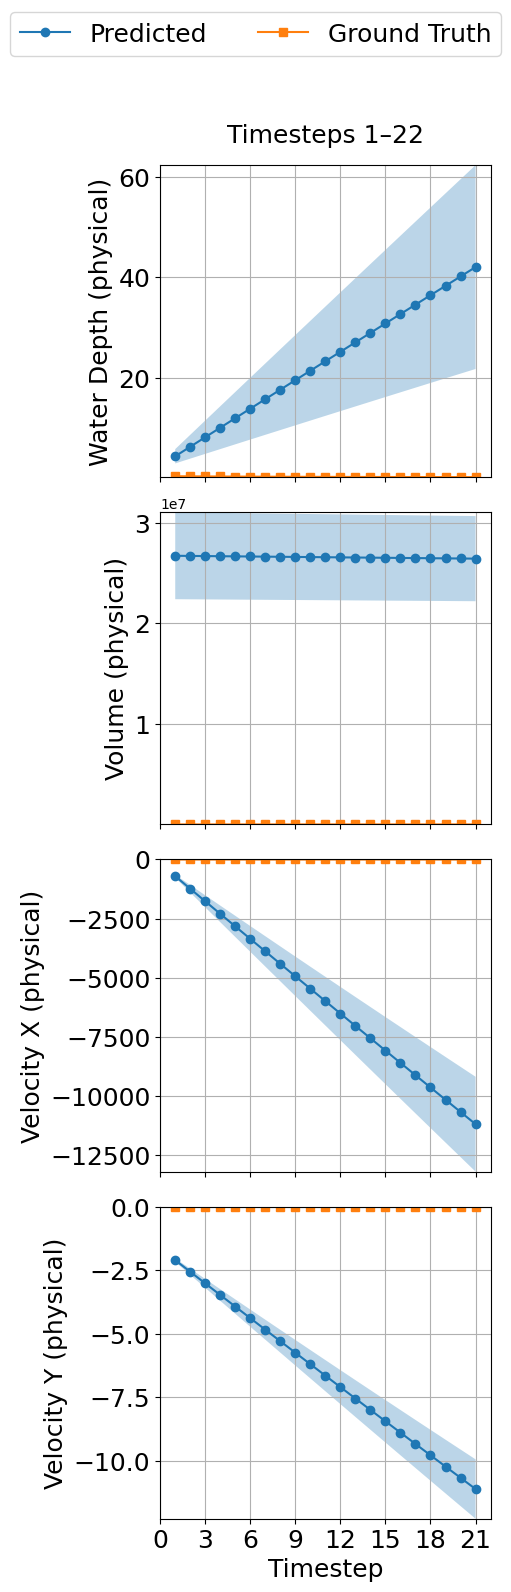

In [16]:
import math
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Ensure you have access to the denormalization extrema
# from your global scope:
# y_mins, y_maxs = ...

def plot_segments_grid_multiple_variables(
    timesteps,
    list_pred_means,
    list_pred_stds,
    list_gt_means,
    list_gt_stds,
    list_feature_names,
    segments,
    output_filename="multi_segments_plot.png"
):
    """
    Plots time segments as subplots in one figure for multiple dynamic variables.
    """
    title_size = 18
    label_size = 18
    tick_size  = 18
    legend_size= 18

    n_vars      = len(list_pred_means)
    num_segments= len(segments)
    if num_segments == 0:
        print("No segments to plot.")
        return

    fig, axes = plt.subplots(
        n_vars, num_segments,
        figsize=(num_segments * 5, n_vars * 4),
        squeeze=False, sharey='row'
    )

    common_handles, common_labels = None, None

    print("--- Denormalized Data Ranges ---")
    for i in range(n_vars):
        # denormalize for this variable
        y_min = float(y_mins[i])
        y_max = float(y_maxs[i])
        scale = y_max - y_min

        # --- CORRECTED ---
        pm = list_pred_means[i]
        ps = list_pred_stds[i]
        gm = list_gt_means[i]
        gs = list_gt_stds[i]
        feature_name = list_feature_names[i]

        # ADDED: Print the ranges after denormalization
        print(f"Variable: {feature_name}")
        print(f"  - Ground Truth Range: [{gm.min():.4f}, {gm.max():.4f}]")
        print(f"  - Prediction Range:   [{pm.min():.4f}, {pm.max():.4f}]")

        # compute row‐wise y‐limits
        y_low  = min((pm - ps).min(), (gm - gs).min())
        y_high = max((pm + ps).max(), (gm + gs).max())

        for j, (start, end) in enumerate(segments):
            ax = axes[i][j]
            idx = np.where((timesteps >= start) & (timesteps < end))[0]
            if idx.size == 0:
                ax.axis('off')
                continue

            l1, = ax.plot(timesteps[idx], pm[idx], marker='o', label="Predicted")
            ax.fill_between(timesteps[idx], pm[idx]-ps[idx], pm[idx]+ps[idx], alpha=0.3)
            l2, = ax.plot(timesteps[idx], gm[idx], marker='s', label="Ground Truth")
            ax.fill_between(timesteps[idx], gm[idx]-gs[idx], gm[idx]+gs[idx], alpha=0.3)

            if i == 0:
                ax.set_title(f"Timesteps {start}–{end}", fontsize=title_size, pad=16)
                common_handles, common_labels = [l1, l2], ["Predicted", "Ground Truth"]

            if i == n_vars - 1:
                ax.set_xlabel("Timestep", fontsize=label_size)
            else:
                ax.tick_params(axis='x', labelbottom=False)

            if j == 0:
                ax.set_ylabel(f"{feature_name} (physical)", fontsize=label_size)
            else:
                ax.tick_params(axis='y', labelleft=False)

            ax.set_ylim(y_low, y_high)
            ax.grid(True)
            ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
            ax.tick_params(axis='both', labelsize=tick_size)

    if common_handles:
        fig.legend(common_handles, common_labels, loc="upper center", ncol=2, fontsize=legend_size)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    print(f"\nFigure saved as {output_filename}")
    plt.show()


# -----------------------------
# Aggregation & Plotting Cell
# -----------------------------
# After importing y_mins, y_maxs and your model & data:

list_pred_means, list_pred_stds = [], []
list_gt_means,   list_gt_stds   = [], []
list_feature_names = []

for pred_idx in range(4):
    # Aggregate (returns normalized arrays)
    timesteps, pm, ps, gm, gs, fname = aggregate_avg_values_variable_return(
        simulation_files, feature_extractor, model, device, num_static_feats, pred_idx
    )
    print(f"Aggregated {fname} [{pred_idx}] over {len(timesteps)} timesteps")

    list_pred_means.append(pm)
    list_pred_stds.append(ps)
    list_gt_means.append(gm)
    list_gt_stds.append(gs)
    list_feature_names.append(fname)

# Determine segments once
segments, counts, lengths = determine_time_segments(simulation_files, min_segment_length=10, drop_threshold=0.8)
print(f"Determined segments: {segments}")

# Plot all four variables
plot_segments_grid_multiple_variables(
    timesteps,
    list_pred_means,
    list_pred_stds,
    list_gt_means,
    list_gt_stds,
    list_feature_names,
    segments,
    output_filename="lower_four_vars_segments_physical.png"
)

In [17]:
import torch
import pickle
from pathlib import Path

# --- Configuration ---
FEATURE_IDX = 1  # 1 for Volume
NUM_STATIC_FEATS = 9

# --- 1. Inspect the data that DEFINED your denormalization scale ---
# This is the data whose min/max values you are using to denormalize
raw_data_dir = Path("/scratch/jtb3sud/hecras/combined/test")
# You can change the filename to any file in that directory
raw_file_path = raw_data_dir / "H126iw.pkl" 

print(f"🔎 Inspecting raw file that created the scaling factors: {raw_file_path.name}")
with open(raw_file_path, 'rb') as f:
    raw_graphs = pickle.load(f)

# Collect all physical 'y' values for Volume from this file
raw_y_values = torch.cat([g.y[:, FEATURE_IDX] for g in raw_graphs])
print(f"-> Physical 'Volume' range in this file: [{raw_y_values.min():,.2f}, {raw_y_values.max():,.2f}]")
print("-" * 50)


# --- 2. Inspect the data you are actually EVALUATING ---
# This is the data you are feeding to the model for the graph plots
eval_data_dir = Path("/scratch/jtb3sud/lower_iowa_river_norm")
eval_file_path = eval_data_dir / "H8ds.pkl" # A sample file you're evaluating

print(f"🔎 Inspecting normalized file being evaluated: {eval_file_path.name}")
with open(eval_file_path, 'rb') as f:
    norm_graphs = pickle.load(f)
    
# Get the true PHYSICAL values for Volume before they were normalized
# (You have to load the original raw file for this)
original_raw_path = Path('/scratch/jtb3sud/lower_iowa_river') / eval_file_path.name
with open(original_raw_path, 'rb') as f:
    original_graphs = pickle.load(f)
original_y_values = torch.cat([g.y[:, FEATURE_IDX] for g in original_graphs])
print(f"-> Actual physical 'Volume' range in this file: [{original_y_values.min():,.2f}, {original_y_values.max():,.2f}]")
print("-" * 50)


# --- 3. Demonstrate the Mismatch ---
# Load the problematic extrema file (created from the 'hecras' data)
extrema_path = Path("/home/jtb3sud/G-PARC/demos/new_river/global_y_extrema_test.pth")
ext = torch.load(extrema_path)
y_min, y_max = ext['y_min'][FEATURE_IDX], ext['y_max'][FEATURE_IDX]

print(f"🚨 Using mismatched denormalization scale: [{y_min:,.2f}, {y_max:,.2f}]")

# Take an average normalized value from your evaluation file
norm_x_values = torch.cat([g.x[:, NUM_STATIC_FEATS + FEATURE_IDX] for g in norm_graphs])
sample_normalized_value = norm_x_values.mean()

# Apply the mismatched scaling
reconstructed_physical_value = sample_normalized_value * (y_max - y_min) + y_min
print(f"\nA sample normalized value of {sample_normalized_value:.4f} from the 'lower_iowa_river' data...")
print(f"...is incorrectly scaled to a physical value of {reconstructed_physical_value:,.2f}!")

🔎 Inspecting raw file that created the scaling factors: H126iw.pkl
-> Physical 'Volume' range in this file: [0.00, 7,550.64]
--------------------------------------------------
🔎 Inspecting normalized file being evaluated: H8ds.pkl
-> Actual physical 'Volume' range in this file: [0.00, 7,509.09]
--------------------------------------------------
🚨 Using mismatched denormalization scale: [0.00, 28,326.70]

A sample normalized value of 176.3681 from the 'lower_iowa_river' data...
...is incorrectly scaled to a physical value of 4,995,927.00!


In [ ]:
import pickle
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import Normalize
import h5py

Y_FEATURE_MAPPING = {
    0: "Water Depth",
    1: "Volume",
    2: "Velocity X",
    3: "Velocity Y"
}

def plot_still_images_for_feature(
    file_path: Path,
    model: torch.nn.Module,
    device: torch.device,
    pred_idx: int,
    mesh_hdf_path: Path,
    facepts_ds: str,
    cells_ds: str,
    num_static_feats: int = 9,
    n_samples: int = 5,
    max_timesteps: int = 200,
    output_filename: Path = None
):
    if output_filename is None:
        output_filename = file_path.with_name(f"{file_path.stem}_feat{pred_idx}.png")

    # 1) Load graphs
    with open(file_path, 'rb') as f:
        graphs = pickle.load(f)
    T = min(len(graphs) - 1, max_timesteps)
    if T < 1:
        print("Not enough timesteps.")
        return

    # 2) Rollout to collect normalized GT & pred
    current = graphs[0].clone().to(device)
    gt_list, pr_list = [], []
    for t in range(1, T + 1):
        with torch.no_grad():
            F_pred = model([current])[0]
        g = graphs[t]
        gt_norm = (g.y[:, pred_idx] if hasattr(g, 'y')
                   else g.x[:, num_static_feats + pred_idx])
        gt_list.append(gt_norm.cpu().numpy())
        pr_list.append(F_pred[:, pred_idx].cpu().numpy())
        # update state
        nx = current.x.clone()
        nx[:, num_static_feats:] = F_pred
        current = current.clone(); current.x = nx

    # 3) Denormalize
    y_min = float(y_mins[pred_idx])
    y_max = float(y_maxs[pred_idx])
    gt_phys = [arr * (y_max - y_min) + y_min for arr in gt_list]
    pr_phys = [arr * (y_max - y_min) + y_min for arr in pr_list]

    # 4) Load mesh
    with h5py.File(mesh_hdf_path, 'r') as f:
        facepts = f[facepts_ds][:]
        cells = f[cells_ds][:]

    # 5) Determine sample indices
    sample_idxs = np.linspace(0, T - 1, n_samples, dtype=int)

    # 6) Compute color scale across all sampled frames
    all_vals = np.concatenate(gt_phys + pr_phys)
    vmin = max(0.0, all_vals.min()) if pred_idx in [0, 1] else all_vals.min()
    vmax = all_vals.max()
    norm = Normalize(vmin=vmin, vmax=vmax)

    # 7) Build cell polygons once
    polys = []
    for verts in cells:
        valid = (verts >= 0) & (verts < len(facepts))
        pts = facepts[verts[valid].astype(int)]
        if len(pts) >= 3:
            polys.append(pts)

    feature_name = Y_FEATURE_MAPPING[pred_idx]
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 4, 8), constrained_layout=False)
    fig.subplots_adjust(top=0.85, hspace=0.01, wspace=0.01)

    for col, idx in enumerate(sample_idxs):
        # Top row: Ground Truth
        ax_gt = axes[0, col]
        vals_gt = gt_phys[idx]
        errs_gt = [vals_gt[i] for i in range(len(polys))]
        pc_gt = PolyCollection(
            polys,
            array=np.array(errs_gt),
            cmap="viridis",
            edgecolors="k",
            linewidths=0.2,
            norm=norm
        )
        ax_gt.add_collection(pc_gt)
        ax_gt.autoscale_view()
        ax_gt.axis('off')
        ax_gt.set_title(f"T={idx+1}", fontsize=16, pad=5)

        # Bottom row: Prediction
        ax_pr = axes[1, col]
        vals_pr = pr_phys[idx]
        errs_pr = [vals_pr[i] for i in range(len(polys))]
        pc_pr = PolyCollection(
            polys,
            array=np.array(errs_pr),
            cmap="viridis",
            edgecolors="k",
            linewidths=0.2,
            norm=norm
        )
        ax_pr.add_collection(pc_pr)
        ax_pr.autoscale_view()
        ax_pr.axis('off')

    # Row labels
    fig.text(0.045, 0.75, 'Ground Truth', va='center', ha='left', fontsize=18)
    fig.text(0.06, 0.35, 'Prediction', va='center', ha='left', fontsize=18)

    # Common colorbar
    sm = plt.cm.ScalarMappable(norm=norm, cmap="viridis")
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label(f"{feature_name} (m)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    #fig.suptitle(f"{feature_name} Rollout", fontsize=22, y=1.02)

    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight", dpi=300)
        print(f"Saved still image to {output_filename}")
    plt.show()


In [ ]:
iowa_mesh = Path("/home/jtb3sud/G-PARC/demos/mesh_cells/Flood_GNN.p01.hdf")
face_iowa = "Geometry/2D Flow Areas/Flow Area/FacePoints Coordinate"
cells_iowa= "Geometry/2D Flow Areas/Flow Area/Cells FacePoint Indexes"

white_mesh = Path("/home/jtb3sud/G-PARC/demos/mesh_cells/Muncie2D_SI.p02.hdf")
face_white= "Geometry/2D Flow Areas/Perimeter 1/FacePoints Coordinate"
cells_white="Geometry/2D Flow Areas/Perimeter 1/Cells FacePoint Indexes"

lower_mesh = Path("/home/jtb3sud/G-PARC/demos/mesh_cells/lower.p01.hdf")
face_lower = "Geometry/2D Flow Areas/Perimeter 1/FacePoints Coordinate"
cells_lower = "Geometry/2D Flow Areas/Perimeter 1/Cells FacePoint Indexes"

sim_iowa  = Path("/scratch/jtb3sud/combined/test/normalized/H147iw.pkl")
sim_white = Path("/scratch/jtb3sud/combined/test/normalized/H379.pkl")
sim_lower = Path("/scratch/jtb3sud/lower_iowa_river_norm/H8ds.pkl")

# Plot water depth for Iowa
plot_still_images_for_feature(sim_iowa, model, device, pred_idx=0,
                             mesh_hdf_path=iowa_mesh,
                             facepts_ds=face_iowa, cells_ds=cells_iowa,
                             output_filename=Path("iowa_depth.png"))

# Plot water depth for White
plot_still_images_for_feature(sim_white, model, device, pred_idx=0,
                             mesh_hdf_path=white_mesh,
                             facepts_ds=face_white, cells_ds=cells_white,
                             output_filename=Path("white_depth.png"))

plot_still_images_for_feature(sim_lower, model, device, pred_idx=0,
                             mesh_hdf_path=lower_mesh,
                             facepts_ds=face_lower, cells_ds=cells_lower,
                             output_filename=Path("white_depth.png"))
